In [2]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing
from sklearn.impute import SimpleImputer

import tensorflow as tf
from tensorflow import keras

import scipy.stats as stats

import my_module

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.2f}".format

sns.set_theme(style="darkgrid")
cm = px.colors.sequential.Bluered

warnings.filterwarnings("ignore")

In [3]:
# import sys

# sys.path.insert(1, '/kaggle/input/mymodules')

# import my_module

In [4]:
# PATH = '/kaggle/input/house-prices-advanced-regression-techniques/'
PATH = ""

train = pd.read_csv(f"{PATH}train.csv")
train.drop(["Id"], axis=1, inplace=True)

test = pd.read_csv(f"{PATH}test.csv")
test_ID = test["Id"]

test.drop(["Id"], axis=1, inplace=True)

df = pd.concat([train, test], ignore_index=True)

df.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
2914,160,RM,21.00,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,160,RM,21.00,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,20,RL,160.00,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,85,RL,62.00,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN
2918,60,RL,74.00,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,11,2006,WD,Normal,NaN


<a id='1'> </a>

# 1. EDA


Let's all delete all columns with a lot of nan values


In [5]:
df = my_module.delete_nan_column(df, 0.25)

In [6]:
df["Train_test"] = df["SalePrice"].isnull().apply(lambda x: "Test" if x else "Train")

<a id='1.1'> </a>

## 1.1 Numeric columns


In [7]:
numeric_features = my_module.get_type_features(df, ["int64", "float64"])

df_corr_sorted = (
    df[numeric_features].corr().sort_values(by=["SalePrice"])[["SalePrice"]].T
)

px.imshow(df_corr_sorted, color_continuous_scale=cm)

<a></a>

### SalePrice


In [8]:
px.histogram(df, x="SalePrice", color_discrete_sequence=cm)

I'll delete the houses which price are above 500k, because we don't have many of them.


In [9]:
df.drop(df[df["SalePrice"] > 500000].index, inplace=True)

In [10]:
px.histogram(df, x="SalePrice", color_discrete_sequence=cm)

<a> </a>

### OverallQual


In [11]:
px.histogram(df, x="OverallQual", color="Train_test", color_discrete_sequence=cm)

Strong exponential dependence. I don't think that I should change anything here


<a id='1.1.2'> </a>

### GrLivArea


In [12]:
px.histogram(df, x="GrLivArea", color="Train_test", color_discrete_sequence=cm)

We can notice the obvious outliers in the area above 3000. I'll delete several rows in the train data and change the values for the others in the test data


In [13]:
df.drop(df[(df["GrLivArea"] > 5000) & ~df["SalePrice"].isnull()].index, inplace=True)
df.loc[df["GrLivArea"] > 2800, "GrLivArea"] = 2800

In [14]:
px.histogram(df, x="GrLivArea", color="Train_test", color_discrete_sequence=cm)

<a> </a>

### GarageCars


In [15]:
px.histogram(df, x="GarageCars", color="Train_test", color_discrete_sequence=cm)

In [16]:
df.loc[df["GarageCars"] == 5, "GarageCars"] = 4

<a> </a>

### GarageArea


In [17]:
px.histogram(df, x="GarageArea", color="Train_test", color_discrete_sequence=cm)

Let's change zeros to small values to help NN to deal with that. Plus, as I've done before, some rare big values will be changed


In [18]:
df.loc[df["GarageArea"] == 0, "GarageArea"] = 0.1
df.loc[df["GarageArea"] > 950, "GarageArea"] = 950

In [19]:
px.histogram(df, x="GarageArea", color="Train_test", color_discrete_sequence=cm)

<a> </a>

### TotalBsmtSF


In [20]:
px.histogram(df, x="TotalBsmtSF", color="Train_test", color_discrete_sequence=cm)

In [21]:
df.loc[df["TotalBsmtSF"] == 0, "TotalBsmtSF"] = 0.1
df.loc[df["TotalBsmtSF"] > 2250, "TotalBsmtSF"] = 2250

In [22]:
px.histogram(df, x="TotalBsmtSF", color="Train_test", color_discrete_sequence=cm)

<a> </a>

### 1stFlrSF


In [23]:
px.histogram(df, x="1stFlrSF", color="Train_test", color_discrete_sequence=cm)

In [24]:
df.loc[df["1stFlrSF"] > 2500, "1stFlrSF"] = 2500

In [25]:
px.histogram(df, x="1stFlrSF", color="Train_test", color_discrete_sequence=cm)

<a id="2"></a>

# 2. Preprocessing


I will delete all columns with a lot of nan values


In [26]:
df = my_module.delete_nan_column(df, 0.25)

numeric_features = my_module.get_type_features(df, ["int64", "float64"])
categorical_features = my_module.get_type_features(df, ["object"])

Imput median values in the numeric columns


In [27]:
for col in numeric_features[:-1]:
    imp = SimpleImputer(missing_values=np.nan, strategy="median")
    df[[col]] = imp.fit_transform(df[[col]])
df[numeric_features[:-1]].isnull().sum().sum()

0

In [28]:
predictive_features = my_module.get_corr_features(
    df[numeric_features].corr()["SalePrice"], 0.6
)
df_final = df[predictive_features].copy(deep=True)
df_final.head()

,OverallQual,TotalBsmtSF,1stFlrSF,GrLivArea,GarageCars,GarageArea,SalePrice
0,7.00,856.00,856.00,1710.00,2.00,548.00,208500.00
1,6.00,1262.00,1262.00,1262.00,2.00,460.00,181500.00
2,7.00,920.00,920.00,1786.00,2.00,608.00,223500.00
3,7.00,756.00,961.00,1717.00,3.00,642.00,140000.00
4,8.00,1145.00,1145.00,2198.00,3.00,836.00,250000.00


Get the features with predictive power


In [29]:
scaler = preprocessing.StandardScaler()
df_final[df_final.columns[:-1]] = scaler.fit_transform(df_final.iloc[:, :-1])
df_final.head()

,OverallQual,TotalBsmtSF,1stFlrSF,GrLivArea,GarageCars,GarageArea,SalePrice
0,0.66,-0.45,-0.80,0.47,0.31,0.38,208500.00
1,-0.06,0.53,0.29,-0.48,0.31,-0.04,181500.00
2,0.66,-0.30,-0.63,0.63,0.31,0.67,223500.00
3,0.66,-0.70,-0.52,0.48,1.63,0.83,140000.00
4,1.37,0.25,-0.02,1.50,1.63,1.77,250000.00


<a id="3"></a>

# 3. Model development


<a id='3.1'> </a>

## 3.1 Baseline


In [30]:
df_final.columns

Index(['OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageCars',
       'GarageArea', 'SalePrice'],
      dtype='object')

In [31]:
features = [
    "OverallQual",
    "TotalBsmtSF",
    "GrLivArea",
    "GarageArea",
    "GarageCars",
    "1stFlrSF",
    "SalePrice",
]

df_features = df_final[features]

In [32]:
my_module.test_nulls(df_features.iloc[:, :-1])

Engineered features do not contain nulls.


In [33]:
rng = 0
x = df_features[~df_features["SalePrice"].isna()][df_features.columns[:-1]]
y = df_features[~df_features["SalePrice"].isna()]["SalePrice"]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=rng
)

In [34]:
my_module.check_distribution(x_train, x_test)

,OverallQual,TotalBsmtSF,GrLivArea,GarageArea,GarageCars,1stFlrSF
0,True,True,True,True,True,True


As we predict a continues value, we can use a mean value as a baseline


In [35]:
mean_price = np.full(len(x), np.mean(y))
my_module.print_evaluate_regression(mean_price, y)

MSE: 5168102623.678315
RMSLE: 0.15576295791415082
______


<a id='3.2'></a>

## 3.2 Simple model with a few features with predictive power


In [36]:
x_train.head()

,OverallQual,TotalBsmtSF,GrLivArea,GarageArea,GarageCars,1stFlrSF
478,1.37,1.61,0.49,1.72,1.63,1.52
530,-0.06,1.02,0.04,0.63,0.31,0.96
187,-0.77,-0.93,0.35,-1.39,-1.01,-0.93
156,-0.77,-2.53,-0.95,0.75,0.31,-0.31
313,0.66,2.66,1.16,0.21,0.31,2.38


Final training loss: 930822848.0
Final Validation loss: 699056960.0
10/10 [==============================] - 0s 999us/step
MSE: 837266801.4534895
RMSLE: 0.024481538838026128
______


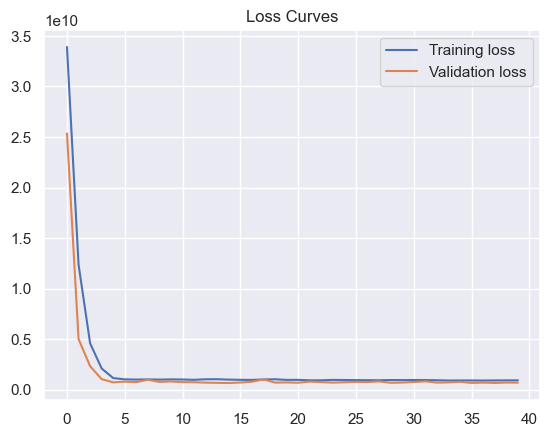

In [37]:
learning_rate = 0.5
epochs = 40
batch_size = 50

model = None

# Define model
model = keras.Sequential()
model.add(
    keras.layers.Dense(
        units=x_train.shape[1],
        activation="relu",
        input_dim=x_train.shape[1],
    ),
)
model.add(
    keras.layers.Dense(
        units=x_train.shape[1],
        activation="relu",
        input_dim=x_train.shape[1],
        kernel_regularizer=tf.keras.regularizers.l2(l2=0.01),
    )
)

model.add(keras.layers.Dense(units=1, activation="linear"))
# Specify the optimizer using the TF API to specify the learning rate
model.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate), loss="mse")

# Train the model
trainHistory = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    verbose=0,
)
# Plot
my_module.showRegressionResults(trainHistory)


my_module.print_evaluate_regression(model.predict(x_test), y_test)

In [38]:
x_sub = df_final.loc[df_final["SalePrice"].isna()][features[:-1]]
pred = model.predict(x_sub, batch_size=batch_size).flatten()

sub = pd.DataFrame({"Id": test_ID, "SalePrice": pred})
sub.to_csv("submission.csv", index=False)

30/30 [==============================] - 0s 1ms/step
